In [ ]:
%load_ext autoreload
%autoreload 2

# Importing ticker data of S&P 400 MidCap Index

Ticker or symbol data of the stocks listed on the S&P 400 MidCap index was scraped from Wikipedia using BeautifulSoup and stored in a pickle file.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

In [ ]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests


def save_sp400_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    names=[]
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
    with open("sp400tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    for row in table.findAll('tr')[1:]:
        name = row.findAll('td')[0].text
        name=name.rstrip('\n')
        names.append(name)
    with open("sp400name.pickle", "wb") as f:
        pickle.dump(names, f)
    return tickers
tickerz=save_sp500_tickers()
def save_sp400_names():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    names=[]
    for row in table.findAll('tr')[1:]:
        name = row.findAll('td')[0].text
        name=name.rstrip('\n')
        names.append(name)
    with open("sp400name.pickle", "wb") as f:
        pickle.dump(names, f)
    return names

In [ ]:
names=save_sp500_names()

In [ ]:
snp400=pd.DataFrame(tickerz)
snp400['name']=names
snp400

## Building a dataframe of prices of S&P400 index using the FinQuant module

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import finquant
# Portfolio weights allocation list for equally weighted
alloc=list([1.00]*400)
pf_allocation=pd.DataFrame({"Name":tickerz,"Allocation":alloc})
pf_allocation

In [ ]:
from finquant.portfolio import build_portfolio
names =  pf_allocation["Name"].values.tolist()

start_date = '2010-01-01'
end_date = '2019-12-31'
pf = build_portfolio(names=names,pf_allocation=pf_allocation,data_api="yfinance",
                    start_date=start_date,
                    end_date=end_date)
pf.data.head(3)

In [ ]:
df=pf.data

In [ ]:
%load_ext autoreload
%autoreload 2
#converting to monthly index
df1=df
df1.index = pd.to_datetime(df1.index, format="%Y%m").to_period('M')

In [ ]:
#keeping only month starting values as month lengths are irregularand contain NaN values 
df1 = df1.loc[~df1.index.duplicated(keep='first')]
df1

## Splitting the dataframe into older and newly listed companies

As 65 companies were listed on the index in between the time frame of analysis(2010-2020), a seperate dataframe is formed for those particular companies with a time frame(2014-2020) where half of these were listed on the index.

In [ ]:
nans=df1.columns[df1.isna().any()]
len(nans)

In [ ]:
newlisted=df1.columns[df1['2014-09':].isna().any()]
len(newlisted)

Thus, roughly halfway in the timeframe, i.e. 2014-09 we find that half of the companies have been listed on the index

In [ ]:
oldstocks=df1.drop(nans,axis=1)
oldies=oldstocks.columns
oldstocks

In [ ]:
newstocks1=df1.drop(newlisted,axis=1)
newstocks=newstocks1.drop(oldies,axis=1)
newstocks=newstocks['2014-09':]
newstocks

Saving the dataframes for later use

In [ ]:
writer = pd.ExcelWriter(r'D:\notebooks_and_codem01_v02\data\oldstockssnp400.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
oldstocks.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
writer = pd.ExcelWriter(r'D:\notebooks_and_codem01_v02\data\newstockssnp400.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
newstocks.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
rets1=oldstocks.pct_change().dropna()

## Importing a module used in a online course for ease and standardized calculation of parameters.

Also calculating covariance matrices to use in calculating global minimum variance and Max Sharpe ratio portfolio weights.

In [ ]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit_206 as erk


In [ ]:
cov1=erk.shrinkage_cov(rets1)
cov1

In [ ]:
rets2=newstocks1.pct_change().dropna()
cov2=erk.shrinkage_cov(rets2)

In [ ]:
cov2

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


## Importing data of Vanguard MidCap ETF(IVOO) which uses stocks from the S&P 400 index(MID).

In [ ]:
import yfinance as yf
data = yf.download("IVOO", start="2009-12-31", end="2020-01-01")
vang=pd.DataFrame(data['Adj Close'],index=data.index)
vang.rename(columns={'Adj Close':'VANG midcap'}, inplace=True)
vang=vang.dropna()
vang.index = pd.to_datetime(vang.index, format="%Y%m").to_period('M')
vang = vang.loc[~vang.index.duplicated(keep='first')]
vang

## Importing FamaFrench Research Data Factors for factor analysis

In [ ]:
ffs = pd.read_csv(r'D:\notebooks_and_codem01_v02\F-F_Research_Data_Factors.CSV',
                       header=0, index_col=0, na_values=-99.99)/100
ffs.index = pd.to_datetime(ffs.index, format="%Y%m").to_period('M')

In [ ]:
ffs1=ffs['2010-02':'2019-12']
ffs1['constant']=1
ffs1.shape

## Importing cap-weighted returns of S&P 400 MidCap Index

In [ ]:
MID=pd.read_csv(r'D:\downloads\^MID.csv', header=0, index_col=0,parse_dates=True)

In [ ]:
MID.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
MID.rename(columns={'Adj Close':'400MID'},inplace=True)
MID=MID[:'2019-12']

In [ ]:
MID=MID.pct_change().dropna()
MID.index = pd.to_datetime(MID.index, format="%Y%m").to_period('M')

In [ ]:
MID=MID[:'2019-12']
MIDexcess=MID['400MID']-ffs1["RF"].values

In [ ]:
ffs2=ffs1.drop(['RF'],1)

In [ ]:
lm=sm.OLS(MIDexcess,ffs2['2010-02':]).fit()
lm.summary()

Thus, Factor analysis of MID index returns shows the 0.4 Size factor indicating the medium sized stocks for which index is made. It also shows positive value 0.1 for the Value factor. Note can be made of the decent alpha or 'manager rating' provided by the cap-weighted index of 13 basis points per month.

In [ ]:
vang=vang.pct_change().dropna()

In [ ]:
vang['vangexcess']=vang['VANG midcap']-ffs1['2010-10':]['RF'].values

In [ ]:
vang=vang.drop(['VANG midcap'],1)

In [ ]:
rm=sm.OLS(vang,ffs2['2010-10':]).fit()
rm.summary()

The factor analysis of Vanguard ETF indicates the tilt of the fund towards 'big' size and growth factors when compared to the S&P index.

## Graphical comparison of wealth returns of the index and the fund.

As the plot indicates although the ETF closely tracks the index, it povides higher excess returns on a riskfree rate average of 2.5% over 2010-2019.

In [ ]:
MIDdf=MID['2010-10':]
MIDdf.reindex(vang.index)

In [ ]:
diag=pd.concat([vang,MIDdf],join='outer',axis=1)
(1+diag).cumprod().plot(figsize=(12,6),title="Vanguard vs S&P MidCap 400")

## Comparison of different weighting schemes on the index and the Vanguard ETF over the time frame.

In [ ]:
oldrets=oldstocks.pct_change().dropna()


The cap-weighted returns of S&P 400 MID are available on Yahoo-Finance.

In [ ]:
cwr=pd.DataFrame(MID['2010':]['400MID'],index=MID.index)
cwr

In [ ]:
cwr1=pd.Series(cwr['400MID'])
cwr1.shape

In [ ]:
cwr.reindex(btr.index)
cwr=cwr['2013':]

Calculations are done using a rolling window of 36 months. 

This markdown cell is the original code but it takes a while to run and thus the dataframe was saved as CSV file.

ewr = erk.backtest_ws(oldrets, estimation_window=36, weighting=erk.weight_ew)
mv_s_r = erk.backtest_ws(oldrets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
mv_cc_r = erk.backtest_ws(oldrets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.cc_cov)
mv_sh_r = erk.backtest_ws(oldrets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"GMV-Shrinkage": mv_sh_r, "EW": ewr, "GMV-Sample": mv_s_r, "GMV-ConstantCorr": mv_cc_r,'CapWeighted':cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Comparison of weighting schemes")
erk.summary_stats(btr.dropna())

In [ ]:
btr=pd.read_csv(r"D:\notebooks_and_codem01_v02\data\btr.csv",header=0, index_col=0,parse_dates=True)
btr.index=pd.to_datetime(btr.index,format='%Y%M').to_period('M')
btr=btr.drop(['Cap-Weighted'],1)
btr['CapWeighted']=cwr

In [210]:
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.138910,0.113336,-0.409969,4.176251,0.044982,0.065986,0.935214,-0.151580
GMV-Sample,0.115787,0.091479,0.334100,4.389457,0.030382,0.043644,0.912678,-0.100962
GMV-CC,0.137005,0.077972,-0.079221,3.491706,0.026076,0.039559,1.335706,-0.059744
GMV-Shrinkage,0.135569,0.078095,-0.091322,3.675594,0.026234,0.040582,1.315701,-0.058007
CapWeighted,0.105794,0.132749,-0.565937,4.075941,0.058582,0.081496,0.555567,-0.186658
vang,0.112467,0.142534,-0.463988,3.690507,0.062172,0.080835,0.562971,-0.189554


In [ ]:
(1+btr[['CapWeighted','EW','GMV-CC']]).cumprod().plot(figsize=(12,6), title="Comparison of weighting schemes")

As expected the GMV portfolios far outperform the Cap-weighted portfolios and the GMV using Constant Correlation outperforms all in terms of Sharpe Ratio. This is important in the sense that the GMV-CC portfolio effectively reduces the parameters, i.e., correlations between the stocks, to provide better calculation and data fitting when large number of stocks are involved.

In [ ]:
vang13=vang['2013':]
btr['vang']=vang13

(1+btr[['vang','GMV-CC','CapWeighted','EW']]).cumprod().plot(figsize=(12,6), title="Comparison of weighting schemes")


In [ ]:
erk.summary_stats(btr.dropna())

## Vanguard ETF outperforms S&P 400 index but falls short of the ideal portfolio using Global Minimum Variance.

Further, returns of the index are analysed from  2014-2019 with additional returns data of companies that were listed between 2010 and 2014.

In [ ]:
newrets=newstocks1.pct_change().dropna()
newrets

In [ ]:
vang2=vang['2014-09':]


In [ ]:
mv_cc_r1 = erk.backtest_ws(newrets, estimation_window=12, weighting=erk.weight_gmv, cov_estimator=erk.cc_cov)
mv_sh_r1 = erk.backtest_ws(newrets, estimation_window=12, weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.5)
ew2= erk.backtest_ws(newrets, estimation_window=12, weighting=erk.weight_ew)
btr1 = pd.DataFrame({"GMV-Shrinkage": mv_sh_r1, "GMV-CC": mv_cc_r1,'Vang':vang2,'EW':ew2})


In [ ]:
(1+btr1).cumprod().plot(figsize=(12,6), title="Comparison of weighting schemes 2015-2019")
erk.summary_stats(btr1.dropna())

As the summary statistics indicate, Vanguard ETF provides a high rate of return but considerably more volatility than the ideal GMV portfolios. Thus, it is doubtful whether the newly listed companies have any major impact on the weighting of the portfolio.

## Sharpe style analysis of the Vanguard ETF in reference to 12 industry portfolio of FamaFrench benchmark.

In [ ]:
ind12 = pd.read_csv(r"D:\downloads\12_Industry_Portfolios_CSV\12_Industry_Portfolios.CSV", header=0, index_col=0, na_values=-99.99)/100

ind12.index = pd.to_datetime(ind12.index, format="%Y%m").to_period('M')
ind12.columns = ind12.columns.str.strip()


In [ ]:
indvang=ind12['2010-10':'2019']

In [ ]:
vangst=pd.read_csv(r"D:\notebooks_and_codem01_v02\data\vang.csv",header=0,index_col=0,parse_dates=True)
vangst.index=vangrets

In [206]:
vangstyle=erk.style_analysis(vangst['VANG midcap'],indvang)*100


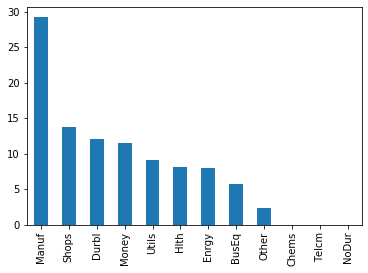

In [207]:
vangstyle.sort_values(ascending=False).head(12).plot.bar()

As seen on Vanguard's official site, the holdings of the IVOO ETF are highest for industrials and information technology followed by financials and lowest are energy and communication. The chart obtained by style analysis shows a similar holdings structure.

## Max Sharpe Ratio Portfolio of the S&P 400 stocks

In [209]:
er=erk.annualize_rets(oldrets,12)
wmsr=erk.msr(0.025,er,cov1)
#Calculating weights of Max Sharpe Ratio Portfolio using quadraticc optimizer 
#and converting the series into a dataframe of 120 rows of weights to multiply with percent returns.
wmsrdf=pd.DataFrame(wmsr)
wmsrdf=wmsrdf.T
msrw=pd.DataFrame(np.repeat(wmsrdf.values,120,axis=0),index=oldrets.index,columns=oldrets.columns)
msr_rets=msrw*oldrets
msrets1=msr_rets.sum(axis=1)

erk.summary_stats(pd.DataFrame(msrets1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.347,0.155198,-0.322929,3.924895,0.050444,0.080078,1.988339,-0.171577


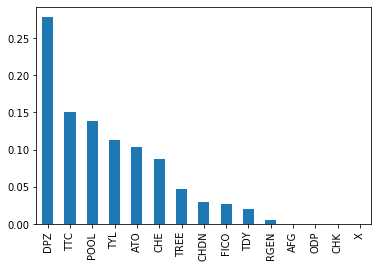

In [211]:
wmsrdf.columns=oldrets.columns
wmsrdf.T[0].sort_values(ascending=False).head(15).plot.bar()

As can be inferred from summary statistics, the MSR portfolio has highest return of all weighting schemes used previously. The chart also shows how some of the stocks with high returns such as TDY,FICO,TYL,POOL,WTRG,RNR are also on Vanguard's top ten holdings list.

Bond portfolio is modeled using 10 year zero coupon bond. The interest rates are modeled using CIR(Cox-Ingersoll-Ross) model of annual averages. The annual average interest rates of 10-year US treasury bills for past 10 years are taken as following:
2019: 2.14 ,
2018: 2.91 ,
2017: 2.33 ,
2016: 1.84 ,
2015: 2.14 ,
2014: 2.54 ,
2013: 2.35 ,
2012: 1.80 ,
2011: 2.78 ,
2010: 3.22

## Asset-Liability Management simulation for 2015-2019

In [212]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit_129 as erk1

rr=0.025

zc_prices=pd.DataFrame()
rates=pd.DataFrame()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
rates,zc_prices = erk1.cir(5,1000, b=0.025, r_0 = 0.032)
zc_prices

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,...,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631,0.858631
1,0.864568,0.878653,0.870329,0.840942,0.854822,0.864802,0.872709,0.866905,0.854551,0.872454,...,0.855904,0.853260,0.853447,0.855192,0.850950,0.853165,0.863613,0.850588,0.845881,0.864987
2,0.876155,0.884650,0.861412,0.828328,0.831958,0.856059,0.869437,0.874904,0.854284,0.872702,...,0.849828,0.832791,0.848074,0.859927,0.845310,0.871941,0.857393,0.850468,0.835931,0.847197
3,0.883049,0.889633,0.871237,0.817517,0.852888,0.848636,0.887052,0.875003,0.845038,0.877959,...,0.853689,0.842532,0.829184,0.860572,0.836661,0.879928,0.862563,0.859362,0.833628,0.842437
4,0.883269,0.890045,0.868169,0.814981,0.848956,0.838123,0.888546,0.883058,0.845993,0.889837,...,0.862937,0.858786,0.832056,0.842870,0.844401,0.883041,0.857891,0.873084,0.849838,0.853912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.997648,0.992009,0.995273,0.972161,0.992096,0.985953,0.995621,0.985322,0.989997,0.990726,...,0.985418,0.984263,0.994327,0.982333,0.975342,0.994533,0.992563,0.988823,0.990821,0.988647
57,0.998267,0.993797,0.995859,0.979525,0.993132,0.989746,0.997017,0.989998,0.992507,0.992532,...,0.989504,0.988465,0.995411,0.987254,0.980495,0.995782,0.994517,0.991406,0.993092,0.990965
58,0.998628,0.995701,0.997684,0.985864,0.995867,0.993311,0.997902,0.993975,0.995356,0.995244,...,0.993711,0.993099,0.996626,0.990932,0.986456,0.997333,0.996638,0.993787,0.995161,0.994082
59,0.999379,0.997598,0.998778,0.992974,0.997750,0.996683,0.999205,0.996507,0.997676,0.997490,...,0.996760,0.996915,0.998156,0.995532,0.993137,0.998585,0.998215,0.997106,0.997563,0.997168


In [233]:
rets_zc=zc_prices.pct_change().dropna()
rets_zc.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,0.013403,0.006825,-0.010245,-0.015000,-0.026748,-0.010109,-0.003750,0.009227,-0.000312,0.000284,...,-0.007100,-0.023990,-0.006296,0.005537,-0.006628,0.022008,-0.007202,-0.000141,-0.011762,-0.020567
3,0.007868,0.005633,0.011405,-0.013051,0.025158,-0.008671,0.020260,0.000114,-0.010823,0.006024,...,0.004544,0.011697,-0.022274,0.000750,-0.010232,0.009160,0.006031,0.010458,-0.002756,-0.005619
4,0.000249,0.000463,-0.003522,-0.003102,-0.004610,-0.012388,0.001685,0.009206,0.001130,0.013529,...,0.010833,0.019292,0.003464,-0.020570,0.009252,0.003538,-0.005416,0.015968,0.019446,0.013621
5,0.015407,-0.002905,0.006392,-0.002680,-0.004514,-0.003287,0.016639,-0.005869,0.012220,-0.008339,...,0.006762,0.016743,0.014307,0.007403,0.006451,-0.007592,-0.001874,0.005927,0.005770,0.006771
6,0.016797,-0.001390,0.004231,-0.010629,0.033927,0.025990,0.018602,0.001068,0.005151,0.002142,...,-0.001887,0.007393,0.026333,0.004873,0.001041,0.000215,-0.000851,-0.000701,0.001775,0.000473


In [232]:
#Returns and Volatility of Vanguard ETF from 2015-2019: 0.075377,0.140850 respectively
vangrets=erk1.gbm(5, 1000,0.075377,sigma=0.140850 ,steps_per_year=12) 
vangrets=vangrets.pct_change().dropna()
vangrets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,-0.028008,-0.058252,-0.050144,-0.029520,0.049577,0.023977,0.009320,-0.059042,0.044451,0.005808,...,0.049587,-0.023209,0.022298,0.030526,-0.018838,0.027926,-0.032383,0.040433,0.030931,-0.048232
2,-0.044832,0.059178,0.026221,-0.103450,-0.064765,0.008571,-0.071187,0.058953,0.031481,-0.057379,...,0.037110,0.011580,0.008577,0.037283,-0.006400,0.000991,0.001373,0.011513,-0.007740,0.083103
3,0.075193,-0.040145,0.040342,-0.004289,0.055606,0.012131,-0.040892,0.004195,-0.024951,-0.011597,...,0.013680,-0.016341,-0.016125,-0.027026,0.061233,-0.017793,-0.001279,0.007336,-0.008732,0.006533
4,0.027782,-0.014568,-0.036449,-0.013456,0.025630,0.024214,-0.017022,-0.001797,-0.011669,0.005103,...,0.008528,-0.102331,-0.040428,0.001668,-0.006789,0.051999,0.025515,0.049637,-0.016200,0.029160
5,0.028176,-0.006069,0.033063,0.078242,0.047475,-0.011044,-0.057739,0.035492,0.062157,-0.026166,...,-0.018353,-0.036058,0.029124,-0.016349,0.036549,0.059354,0.051409,0.038692,0.002107,-0.024502


In [216]:
zc_prices=zc_prices[1:]
zc_prices.shape

(60, 1000)

In [225]:
rets_g8020 = erk1.bt_mix(vangrets,rets_zc, allocator=erk1.glidepath_allocator, start_glide=0.9,end_glide=0.45)
rets_7030z = erk1.bt_mix(vangrets, rets_zc, allocator=erk1.fixedmix_allocator, w1=0.8)
rets_floor75m3 = erk1.bt_mix(vangrets, rets_zc, allocator=erk1.floor_allocator, zc_prices=zc_prices, floor=0.8,m=3)
pd.concat([erk1.terminal_stats(vangrets, name="vangrets",floor=0.8),
           erk1.terminal_stats(rets_7030z, name="fixed7030",floor=0.8 ),
           erk1.terminal_stats(rets_g8020, name="glide8020",floor=0.8 ),
           erk1.terminal_stats(rets_zc,name="zcbonds"),
           erk1.terminal_stats(rets_floor75m3, name="Floor 80%, multiple=4",floor=0.8 )],
          axis=1)


,vangrets,fixed7030,glide8020,zcbonds,"Floor 80%, multiple=4"
mean,1.415777,1.362285,1.328284,1.164645e+00,1.385160
std,0.452400,0.344479,0.285422,3.959610e-15,0.437113
p_breach,0.045000,0.016000,0.009000,NaN,NaN
e_short,0.078577,0.070591,0.058148,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


Thus, as expected the CPPI based floor allocation strategy works best at preserving the rate of return and preventing the asset value to plummet below the floor value.

In [226]:
rets_floor=rets_floor75m3.mean(axis=1)

In [227]:
rets_floor=pd.DataFrame(rets_floor)

In [228]:
vanga=vang[-60:]
vanga.index=rets_floor.index

In [229]:
rets=pd.concat([rets_floor,vanga],axis=1)


In [230]:
rets_floor75m3 = erk1.bt_mix(vangrets, rets_zc, allocator=erk1.floor_allocator, zc_prices=zc_prices, floor=0.8,m=5)
erk.summary_stats(rets)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.066402,0.004015,-0.024508,2.842900,-0.003471,-0.002990,8.825120,0.000000
vangexcess,0.075377,0.140824,-0.482130,4.370063,0.063647,0.092242,0.313445,-0.189554


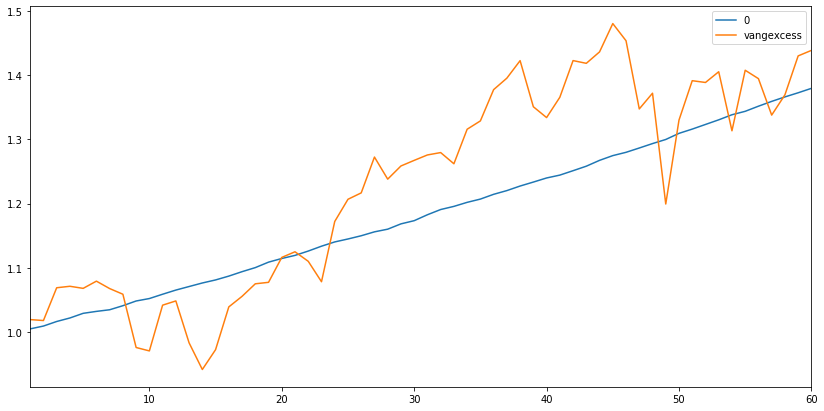

In [231]:
import matplotlib.pyplot as plt
(1+rets).cumprod().plot(figsize=(14, 7))

Thus we see that using a bond portfolio in combination with Vanguard equity portfolio allocation limited to a lower limit of 80% significantly reduces drawdowns and volatility while barely affecting the returns. 